In [9]:
import numpy as np
from pathlib import Path as pt
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
import uncertainties as uc

In [10]:
filename = pt("./12_09_19-2.thz")
filename.exists()

True

In [11]:
# Opening file and reading its content
with open(filename, "r") as fileContents:
    file = fileContents.readlines()
file = file[1:]
#############################################

# Resonce ON counts value
resOn = []

for line in file:
    if line.startswith("#"): break
    line = line.split("\n")[0].split("\t")[:-1]
    resOn.append(line)
    
resOn = resOn[1:]
#############################################

# Resonce OFF counts value
resOff = []
start = False

for line in file:
    if line.startswith("# freq"):
        start = True
        continue
    if start: 
        if line.startswith("#"): break
        line = line.split("\n")[0].split("\t")[:-1]
        resOff.append(line)
        
resOff = resOff[1:]
#############################################

resOn = np.array(resOn, dtype=np.float)
resOff = np.array(resOff, dtype=np.float)

#############################################

freq = resOn.T[0]
depletion = (resOff.T[1:] - resOn.T[1:])/resOff.T[1:]
depletion_counts = depletion.T.mean(axis=1)
depletion_error = depletion.T.std(axis=1)

#############################################
depletion_counts = depletion_counts*100

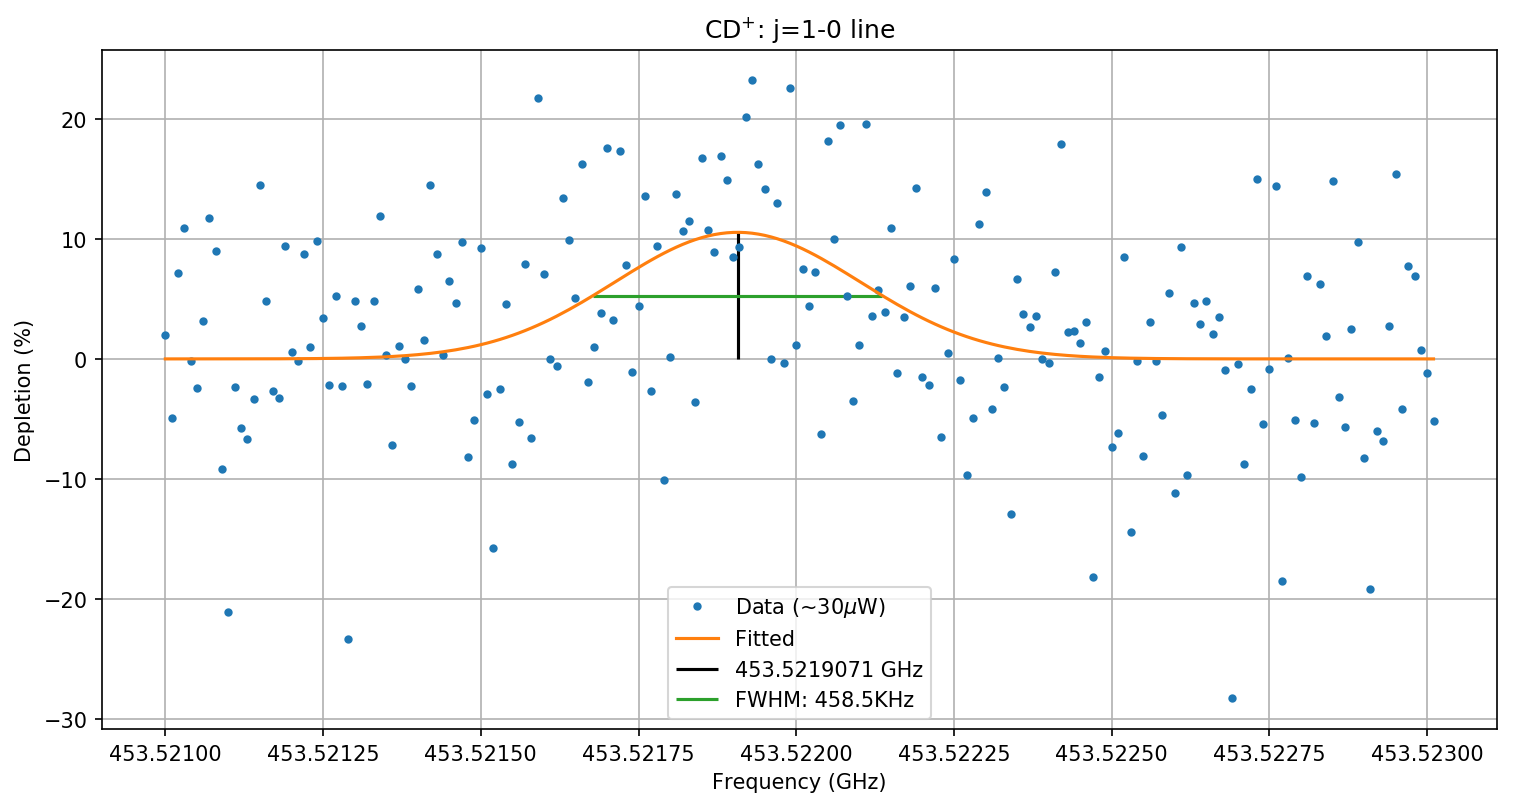

In [12]:
model = GaussianModel()
guess = model.guess(depletion_counts, x=freq)
guess_values = guess.valuesdict()
fit = model.fit(depletion_counts, x=freq, amplitude = guess_values['amplitude'], 
                center = guess_values['center'], 
                sigma = guess_values['sigma'], 
                fwhm = guess_values['fwhm'], 
                height = guess_values['height'])

fit_data = fit.best_fit

line_freq_fit = fit.best_values['center']
##########################################################################################

FWHM = lambda sigma: 2*np.sqrt(2*np.log(2))*sigma
Amplitude = lambda a, sigma: a/(sigma*np.sqrt(2*np.pi))

fwhm = FWHM(fit.best_values['sigma'])
amplitude = Amplitude(fit.best_values['amplitude'], fit.best_values['sigma'])
half_max = amplitude/2
sigma = fit.best_values['sigma']
##########################################################################################

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
#ax.errorbar(freq, depletion_counts, yerr=depletion_error, ecolor ="k")

ax.plot(freq, depletion_counts, ".", label="Data (~30${\mu}$W)")
ax.plot(freq, fit_data, label="Fitted")
ax.vlines(line_freq_fit, 0, amplitude, label=f'{line_freq_fit:.7f} GHz')
ax.hlines(half_max, line_freq_fit-fwhm/2, line_freq_fit+fwhm/2, color="C2", label=f"FWHM: {fwhm*1e6:.1f}KHz")


ax.grid()
ax.set(title="CD$^{+}$: j=1-0 line", xlabel="Frequency (GHz)", ylabel="Depletion (%)")
ax.ticklabel_format(useOffset=False)
ax.legend()

plt.savefig('./CD+_j1-0_line')
plt.show()
plt.close()

In [5]:
fit.fit_report()

'[[Model]]\n    Model(gaussian)\n[[Fit Statistics]]\n    # fitting method   = leastsq\n    # function evals   = 22\n    # data points      = 202\n    # variables        = 3\n    chi-square         = 1402.34594\n    reduced chi-square = 7.04696452\n    Akaike info crit   = 397.402085\n    Bayesian info crit = 407.326889\n[[Variables]]\n    amplitude:  0.01086771 +/- 2.6323e-04 (2.42%) (init = 0.05977773)\n    center:     453.521848 +/- 5.1584e-06 (0.00%) (init = 453.5219)\n    sigma:      1.8131e-04 +/- 5.1069e-06 (2.82%) (init = 0.00061)\n    fwhm:       0.00143644 (fixed)\n    height:     39.09486 (fixed)\n[[Correlations]] (unreported correlations are < 0.100)\n    C(amplitude, sigma) =  0.577'